<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Model Train and Evaluation: DecisionTree </b></font></font></th>
   </tr> 
</table>

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
#!pip install watermark
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-20 

CPython 3.8.3
IPython 7.18.1

numpy 1.19.4
pandas 1.1.3
scipy 1.4.1
matplotlib 3.3.2
sklearn 0.23.2
mlxtend 0.17.3


In [2]:
import os
import numpy as np
import pandas as pd
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions

#### Loading the IRIS dataset

In [3]:
""" UCI Adult Dataset (1994 Census)
    https://archive.ics.uci.edu/ml/machine-learning-databases/adult
    features: 14
    examples: 48842
feature type: categorical and numerical
        task: predict wheather a person makes above 50k a year
"""

COLUMNS = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                 "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", 
                 "hours-per-week", "native-country", "income"]
# PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
# df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)

df = pd.read_csv('./data/adult.csv', index_col=None)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

new_df = df.loc[:, ~df.columns.isin(['workclass','occupation','native-country'])]
new_df.loc[:,'education'] = le.fit_transform(new_df.loc[:,'education'].values)
new_df.loc[:,'marital-status'] = le.fit_transform(new_df.loc[:,'marital-status'].values)
new_df.loc[:,'relationship'] = le.fit_transform(new_df.loc[:,'relationship'].values)
new_df.loc[:,'race'] = le.fit_transform(new_df.loc[:,'race'].values)
new_df.loc[:,'sex'] = le.fit_transform(new_df.loc[:,'sex'].values)
new_df.loc[:,'income'] = le.fit_transform(new_df.loc[:,'income'].values)



C:\ProgramData\Miniconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [5]:
new_df.head()

,age,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,39,77516,9,13,4,1,4,1,2174,0,40,0
1,50,83311,9,13,2,0,4,1,0,0,13,0
2,38,215646,11,9,0,1,4,1,0,0,40,0
3,53,234721,1,7,2,0,2,1,0,0,40,0
4,28,338409,9,13,2,5,2,0,0,0,40,0


In [6]:
X = new_df.drop('income', axis=1).values
y = new_df['income'].values

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [8]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (22792, 11)
y_train.shape: (22792,)
X_test.shape: (9769, 11)
y_test.shape: (9769,)


<a id="eda"></a>
## 2. Exploratory Data Analysis

In [9]:
mean = new_df.groupby(['income']).mean()
mean

,age,fnlwgt,education,education-num,marital-status,relationship,race,sex,capital-gain,capital-loss,hours-per-week
income,,,,,,,,,,,
0,36.783738,190340.86517,10.125324,9.595065,2.780906,1.673422,3.631513,0.611974,148.752468,53.142921,38.840210
1,44.249841,188005.00000,10.843260,11.611657,2.078816,0.730519,3.774136,0.849637,4006.142456,195.001530,45.473026


In [10]:
min_income_age = new_df.groupby(['income'])['age'].min()
min_income_age

income
0    17
1    19
Name: age, dtype: int64

In [11]:
income_by_martial_status = new_df.groupby(['income', 'marital-status'])['capital-gain'].max()
income_by_martial_status

income  marital-status
0       0                 34095
        1                  2653
        2                 41310
        3                  6849
        4                 34095
        5                  7443
        6                  6849
1       0                 99999
        1                  7298
        2                 99999
        3                 99999
        4                 99999
        5                 99999
        6                 99999
Name: capital-gain, dtype: int64

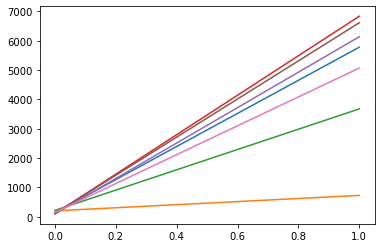

In [12]:
mean_income_by_martial_status = new_df = new_df.groupby(['income', 'marital-status'])['capital-gain'].mean().unstack()
plt.plot(mean_income_by_martial_status)

<a id="classifier"></a>
## 3. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#3_1)
2. [Model Training: Fit a DecisionTree via scikit-learn](#3_2)
3. [Evaluate the model](#3_3)

<a id="3_1"></a>
### 3.1. Data Scaling

Bringing features onto the same scale

<a id="3_1"></a>
### 3.2. Model Training: Fit a DecisionTree via scikit-learn

Train a model using 

In [13]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
model.fit(X_train, y_train)

print(f'model: {model}')

model: DecisionTreeClassifier(max_depth=4, random_state=42)


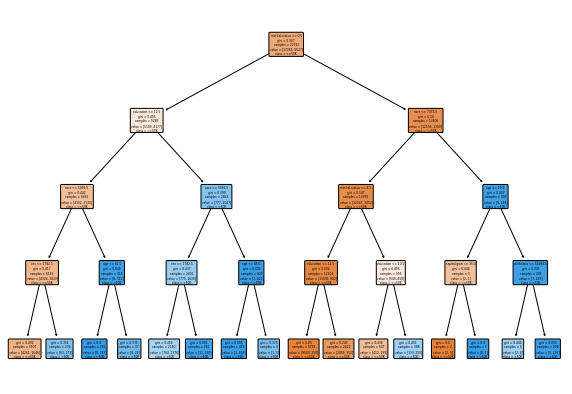

In [14]:
from sklearn.tree import plot_tree

feature_names = COLUMNS[0:len(COLUMNS)-1]

plt.figure(figsize=(10, 7))

plot_tree(model, 
          filled=True, 
          rounded=True,
          class_names=['<=50K', 
                       '>50K'],
          feature_names=feature_names) 
plt.savefig('images/decisiontree_fig1.png', dpi=300)
plt.show()

<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

#### Reading a confusion matrix

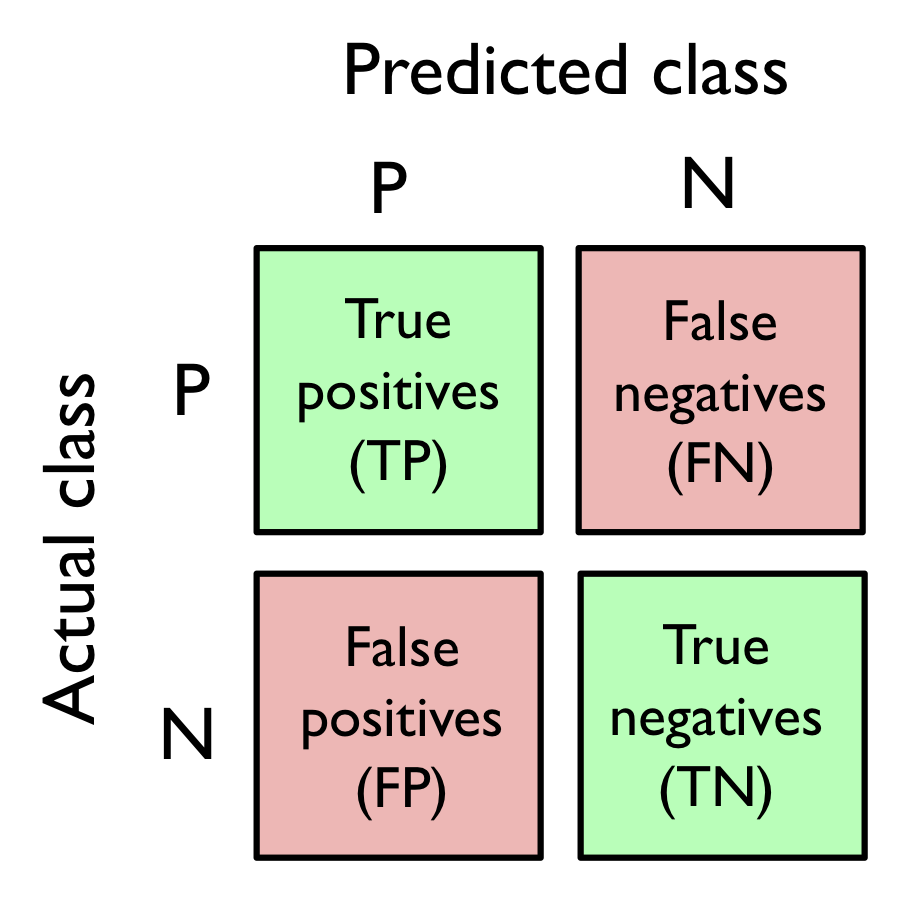

In [15]:
Image(filename='images/confusion_matrix.png', width=300) 

In [16]:
def convert_prob_to_binary(y_pred):
    # convert probabilities to binary prediction using threshold=0.5
    for i in range(0, y_pred.shape[0]):
        if y_pred[i] >= .5: # setting threshold to .5
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    return y_pred

In [17]:
# note: micro-average is preferable if you suspect there might be class imbalance
# ref: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
# Import the libraries
from sklearn import metrics

y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

y_pred = convert_prob_to_binary(y_pred)

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = metrics.roc_auc_score(y_test, y_pred)
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") 
model.score(X_test, y_test)
print(f'Accuracy:{model.score(X_test, y_test)}')

# Precision
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"F1: {f1}")

# classification_report
print('classification_report')
print(metrics.classification_report(y_test, y_pred))

prediction: [0 0 1 ... 0 0 1]
Misclassified examples:1486
confusion matrix:
 [[7036  419]
 [1067 1247]]
auc: 0.7413449002861885
Accuracy: 0.8478861705394616
Accuracy:0.8478861705394616
Precision: 0.8084098874647971
Recall: 0.7413449002861885
F1: 0.7655598018373135
classification_report
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      7455
           1       0.75      0.54      0.63      2314

    accuracy                           0.85      9769
   macro avg       0.81      0.74      0.77      9769
weighted avg       0.84      0.85      0.84      9769



Max f1_score on max_depth   10  is  0.7819219232846961
./images/decisiontree_fig2.png


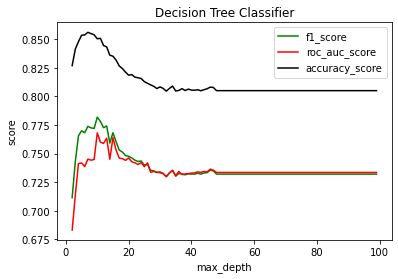

In [18]:
from sklearn import metrics

max_c = 0;
max_j = 0;
y_fsc = []
y_rauc = []
y_acc = []
y_ll = []

x_vals = None

for j in range(2, 100):
    x_vals = np.arange(2, 100)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f_sc = metrics.f1_score(y_test, y_pred, average='macro')
    y_fsc.append(f_sc)
    r_auc = metrics.roc_auc_score(y_test, y_pred)
    y_rauc.append(r_auc)
    acc = metrics.accuracy_score(y_test, y_pred)
    y_acc.append(acc)
    if f_sc > max_c:
        max_c = f_sc
        max_j = j

print("Max f1_score on max_depth  ",  max_j, " is ", max_c)
plt.figure()
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('Decision Tree Classifier')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
plt.plot(x_vals, y_rauc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")
plt.legend()
filename=os.path.join('./images/', 'decisiontree_fig2.png')
print(filename)
plt.savefig(filename, dpi=300)
plt.show()

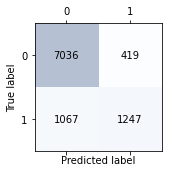

In [19]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('images/decisiontree_fig3.png', dpi=300)
plt.show()

#### K-fold cross-validation


https://nbviewer.jupyter.org/github/vmirly/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb

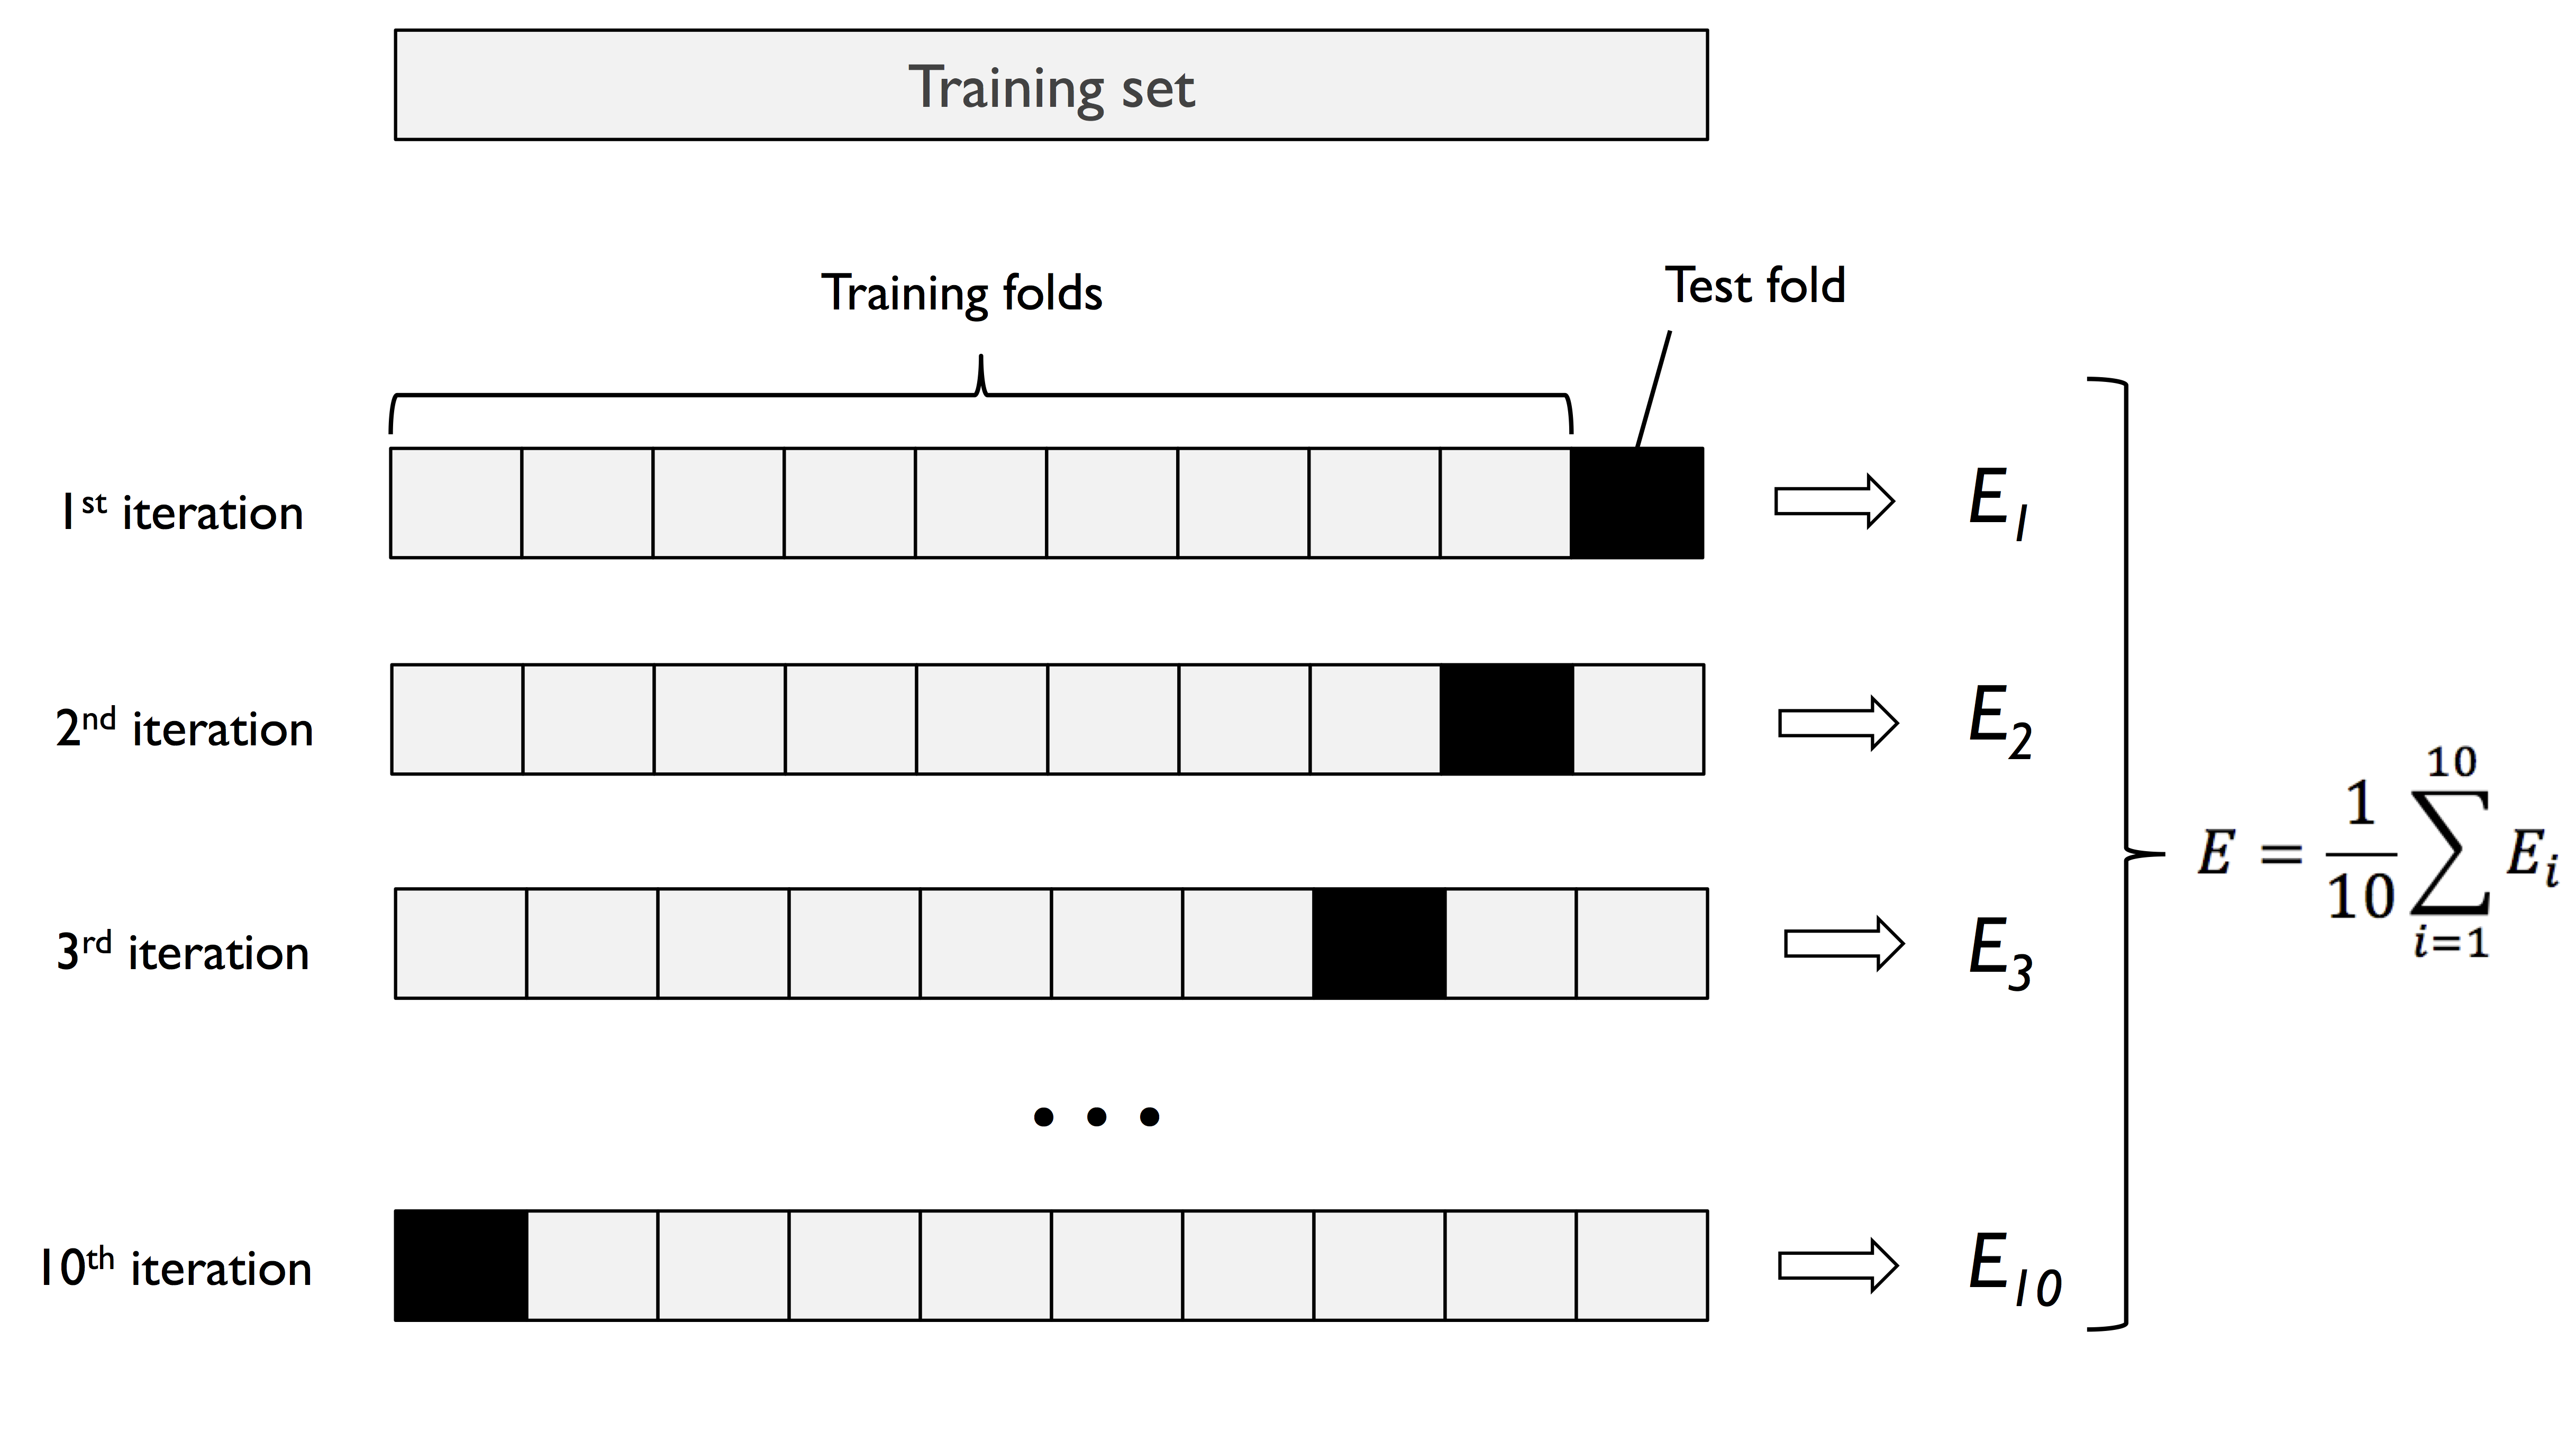

In [21]:
Image(filename='images/kfold.png', width=500)

In [22]:
from sklearn.model_selection import StratifiedKFold    

# CV accuracy: 0.845 +/- 0.006
clf = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=123)

kfold = StratifiedKFold(n_splits=10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
    clf.fit(X[train], y[train])
    score = clf.score(X[test], y[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
           np.bincount(y[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [22248  7056], Acc: 0.836
Fold:  2, Class dist.: [22248  7057], Acc: 0.846
Fold:  3, Class dist.: [22248  7057], Acc: 0.851
Fold:  4, Class dist.: [22248  7057], Acc: 0.835
Fold:  5, Class dist.: [22248  7057], Acc: 0.846
Fold:  6, Class dist.: [22248  7057], Acc: 0.845
Fold:  7, Class dist.: [22248  7057], Acc: 0.846
Fold:  8, Class dist.: [22248  7057], Acc: 0.852
Fold:  9, Class dist.: [22248  7057], Acc: 0.851
Fold: 10, Class dist.: [22248  7057], Acc: 0.840

CV accuracy: 0.845 +/- 0.006


In [23]:
import joblib
MODEL = "DecisionTreeClassifier"
joblib.dump(model, f"models/local/{MODEL}.pkl")

['models/local/DecisionTreeClassifier.pkl']

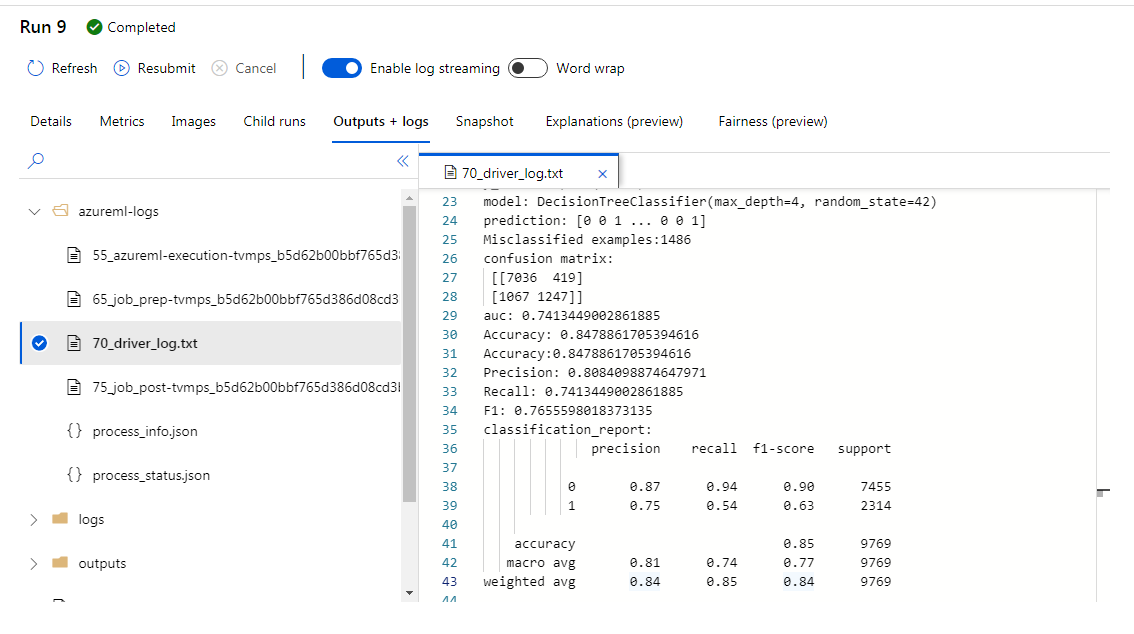

In [24]:
Image(filename='images/Azure/Exp-2/DecisionTree/driver_log.png')

## 5 Result Analysis

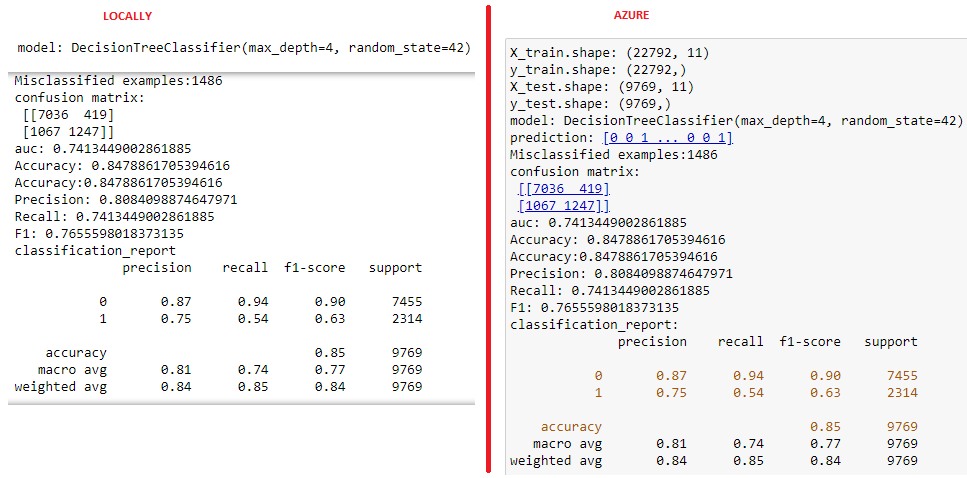

In [26]:
Image(filename='images/Azure/Exp-2/DecisionTree/result.png')

## 6 Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [ ]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

### Experiment : 2

Generate adversarial samples:

In [ ]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

1. Score
2. Predict

##### Score

In [ ]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

In [ ]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

#### Predict

In [ ]:
print(X_train[0:5, :])
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

In [ ]:
print(X_train_adv[0:5, :])
prediction = model.predict(X_train_adv[0:5, :])
prediction
print(f"Adversarial Training Predicted Label: {prediction}")

##### Test score

In [ ]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

In [ ]:
print(X_test[:5, :])
prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

In [ ]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

In [ ]:
print(X_test_adv[0:5, :])
prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")